# Projet Bayes 2 - Hearts

Auteurs:
- Karim CHAKROUN
- Maxime GOURCEYRAUD
- Charles MIRANDA
- Vincent SEVESTRE

## Importation des données

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
path = "data.csv" # chemin du jeu de données

Le jeu de données correspond à l'effet d'un médicament utilisé pour traiter des patients souffrant de fréquentes contractions ventriculaires prématurées (CVP) du coeur.

- $x_i$ est le nombre de CVP par minute avant la prise du médicament
- $y_i$ est le nombre de CVP par minute après la prise du médicament
- $t_i=x_i+y_i$

In [15]:
data = pd.read_csv(path)
data = data.iloc[:, 1:] # on enlève la première colonne puisqu'elle contient juste les indices
data

,t,x,y
0,11,6,5
1,11,9,2
2,17,17,0
3,22,22,0
4,9,7,2
5,6,5,1
6,5,5,0
7,14,14,0
8,9,9,0
9,7,7,0


## Échantilloneur

Farewell et Sprott ont modélisé ces données en 1988 comme un mélange de distributions de Poisson dans lequel certains patients sont "guéris" par le médicament, tandis que d'autres présentent des niveaux variables de réponse mais restent anormaux. Une valeur nulle après la prise du médicament peut indiquer une "guérison", ou peut représenter un zéro d'échantillonnage d'un patient avec un CVP anormal. Le modèle suivant est donc supposé
$$
x_i \sim \mathcal P(\lambda_i) ~ ,\text{pour tous les patients} \\
y_i \sim \mathcal P(\beta \lambda_i) ~ ,\text{pour tous les patients }\textit{non soignés} \\
\mathbb P(Cure) = \theta
$$

Pour éliminer les paramètres de nuisance $\lambda_i$, Farewell et Sprott utilisent la distribution conditionnelle de $y_i$ sachant $t_i = x_i + y_i$. C'est équivalent à une vraisemblance binomiale de $y_i$ parmi $t_i$ avec une probabilité $p = \frac{\beta}{1+\beta}$. Le modèle de mélange final est donc
$$
\mathbb P(y_i = 0 | t_i) = \theta + (1-\theta)(1-p)^{t_i} \\
\mathbb P(y_i | t_i) = (1-\theta) \binom{t_i}{y_i} p^{y_i}(1-p)^{t_i-y_i} ~ \text{pour} ~ y_i > 0
$$

Afin de pouvoir déterminer $\beta$ et $\theta$ nous considérons les lois à priori $\alpha, \delta \sim \mathcal N(0, \sigma^2)$, avec $\sigma^2 = 10^4$, telles que
$$
\operatorname{logit}(p) = \alpha \iff \beta = \exp(\alpha) \\
\operatorname{logit}(\theta) = \delta
$$

Après calculs et simplification nous obtenons les densités suivantes
$$
\begin{align*}
    \pi(\alpha | \mathbf y, \delta) &\propto \pi(\alpha) \prod_{i = 1}^n{\pi(y_i | \alpha, \delta)} \\
    &\propto \exp(-\frac{\alpha^2}{2\sigma^2}) \left(\prod_{\substack{i = 1 \\ y_i = 0}}^n(\theta + (1-\theta)(1-p)^{t_i})\right) \left(\prod_{\substack{i = 1 \\ y_i > 0}}^n(1-\theta)p^{y_i}(1-p)^{t_i-y_i}\right)
\end{align*}
$$
et donc par passage au $\log$
$$
\log \pi(\alpha | \mathbf y, \delta) = cst - \frac{\alpha^2}{2\sigma^2} + \sum_{\substack{i = 1 \\ y_i = 0}}^n\log(\theta + (1-\theta)(1-p)^{t_i}) + \sum_{\substack{i = 1 \\ y_i > 0}}^n(y_i\log{p} + (t_i-y_i)\log(1-p))
$$

Par analogie pour $\delta$ on obtient
$$
\log \pi(\delta | \mathbf y, \alpha) = cst - \frac{\delta^2}{2\sigma^2} + \sum_{\substack{i = 1 \\ y_i = 0}}^n\log(\theta + (1-\theta)(1-p)^{t_i}) + \sum_{\substack{i = 1 \\ y_i > 0}}^n\log(1-\theta)
$$

In [4]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [16]:
init = [0, # alpha
        0] # delta

In [26]:
def MH(data, init, n, prop_sd, sigma = 1e2):
    # X = [alpha, beta, delta, theta]
    X = np.zeros((n+1,4), dtype=np.float32)
    X[0] = [init[0],
            np.exp(init[0]),
            init[1],
            sigmoid(init[1])]
    
    id0 = (data["y"] == 0)
    cured = data[id0]
    not_cured = data[~id0]
    
    # Calcul des probas d'acceptation
    P = [0,0]
    
    for i in range(1,n+1) :
        # Calcul de alpha
        alpha = X[i-1,0]
        theta = X[i-1,3]
        prop_alpha = np.random.normal(alpha,prop_sd[0])
        
        def log_pdf_alpha(x):
            # dans ce cas theta est fixé
            p = sigmoid(x)
            
            s = -(x**2)/(2*sigma**2) + \
                np.sum(np.log(theta + (1-theta)*(1-p)**cured["t"])) + \
                np.sum(not_cured["y"]*np.log(p) + (not_cured["t"] - not_cured["y"])*np.log(1-p))
            
            return s
        
        ## calcul de la proba d'acceptation d'alpha
        top = log_pdf_alpha(prop_alpha)
        bottom = log_pdf_alpha(alpha)
        acc = np.exp(top - bottom)
        
        if np.random.uniform() < acc :
            X[i,0] = prop_alpha
            P[0] +=1
        else : 
            X[i,0] = alpha
        
        # Calcul de delta
        delta = X[i-1,2]
        p = sigmoid(X[i,0])
        prop_delta = np.random.normal(delta,prop_sd[1])
        
        def log_pdf_delta(x):
            # dans ce cas p est fixé
            theta = sigmoid(x)
            
            s = -(x**2)/(2*sigma**2) + \
                np.sum(np.log(theta + (1-theta)*(1-p)**cured["t"])) + \
                np.log(1-theta)*len(not_cured)
            
            return s
        
        ## calcul de la proba d'acceptation de delta
        top = log_pdf_delta(prop_delta)
        bottom = log_pdf_delta(delta)

        acc = np.exp(top - bottom)
        
        if np.random.uniform() < acc :
            X[i,2] = prop_delta
            P[1] += 1
        else : 
            X[i,2] = delta
            
        # Calcul de beta et theta
        X[i,1] = np.exp(X[i,0])
        X[i,3] = sigmoid(X[i,2])
        
    return X, np.array(P)/n

In [27]:
n = 10000
prop_sd = [
    0.05, # alpha
    1 # delta
]
X,P = MH(data, init, n, prop_sd)

## Analyse des résultats

In [28]:
burnin = 1000

X_burn = X[burnin:]
coefficients = ['alpha', 'beta', 'delta', 'theta']

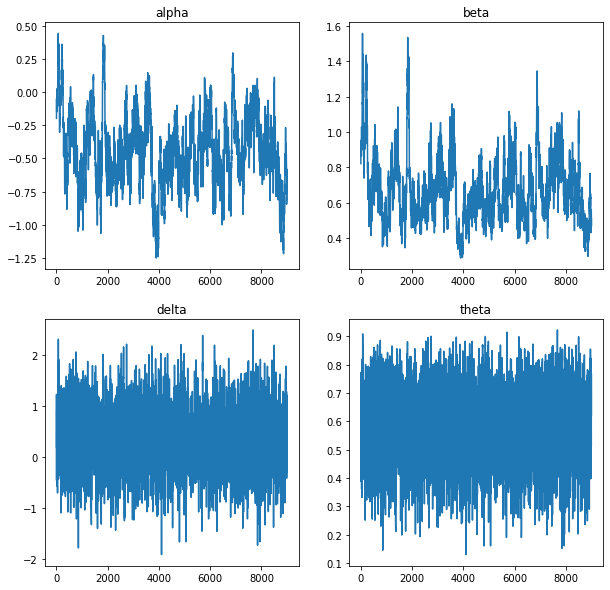

In [29]:
fig = plt.figure(figsize=(10, 10))

for i, coeff in enumerate(coefficients):
    ax = fig.add_subplot(2, 2, 1 + i)
    ax.set_title(coeff)
    ax.plot(X_burn[:, i])

In [10]:
P # proba d'acceptation

array([0.9434, 0.5728])

In [31]:
coef = pd.DataFrame({
    coeff: X_burn[:, i] for i, coeff in enumerate(coefficients)
})
summary = coef.describe(percentiles=[0.025,0.975])
summary

,alpha,beta,delta,theta
count,9001.000000,9001.000000,9001.000000,9001.000000
mean,-0.440262,0.668435,0.315885,0.572062
std,0.272396,0.188216,0.608252,0.137296
min,-1.252164,0.285885,-1.909157,0.129076
2.5%,-0.975509,0.377000,-0.874970,0.294221
50%,-0.447940,0.638943,0.305319,0.575742
97.5%,0.102329,1.107748,1.558110,0.826082
max,0.443986,1.558908,2.483371,0.922968


In [33]:
output_tex = os.path.join("..", "report", "output.tex")
summary.style.to_latex(output_tex)